## Plot Experiment 2

In [1]:
import sys
import pickle
import numpy as np 
import re 
from pathlib import Path
import pandas as pd
import json 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
from src import util_analysis 

import re 

In [2]:
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from pingouin import rm_anova


def bootstrap_partial_eta_ci(
    df: pd.DataFrame,
    dv_col: str,
    subject_col: str,
    within_factors: list[str],
    n_bootstrap: int = 2000,
    ci_level: float = 0.95,
    random_state: int | None = None,
    tqdm_desc: str = "Partial η² bootstrap",
    suppress_future_warnings: bool = True,
):
    """Run pingouin rm_anova and add bootstrap CIs for partial eta squared."""
    if suppress_future_warnings:
        warnings.filterwarnings("ignore", category=FutureWarning)

    rng = np.random.default_rng(random_state)

    # Base ANOVA
    anova_table = rm_anova(
        data=df,
        dv=dv_col,
        subject=subject_col,
        within=within_factors,
        effsize="np2",
    )

    subjects = df[subject_col].unique()
    bootstrap_np2 = {src: [] for src in anova_table["Source"]}

    for _ in tqdm(range(n_bootstrap), desc=tqdm_desc):
        sampled_ids = rng.choice(subjects, size=len(subjects), replace=True)
        boot_df = df[df[subject_col].isin(sampled_ids)].copy()

        try:
            boot_table = rm_anova(
                data=boot_df,
                dv=dv_col,
                subject=subject_col,
                within=within_factors,
                effsize="np2",
            )
            for src, np2 in zip(boot_table["Source"], boot_table["np2"]):
                bootstrap_np2[src].append(np2)
        except Exception:
            continue  # skip occasional singular fits

    alpha = 1 - ci_level
    lower = alpha / 2 * 100
    upper = (1 - alpha / 2) * 100

    anova_table["np2_CI_lower"] = [
        np.percentile(bootstrap_np2[src], lower) if bootstrap_np2[src] else np.nan
        for src in anova_table["Source"]
    ]
    anova_table["np2_CI_upper"] = [
        np.percentile(bootstrap_np2[src], upper) if bootstrap_np2[src] else np.nan
        for src in anova_table["Source"]
    ]

    return anova_table, bootstrap_np2

In [3]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("rebuttal_figs/fig_2")
fig_out_dir.mkdir(exist_ok=True, parents=True)

### Load data

In [4]:
results_dir = Path('data')

results = pd.read_csv(results_dir / "experiment_2_df_for_plot_and_stats.csv")



In [5]:
results.group.unique()

array(['Humans (N = 90)', 'Early-only model', 'Late-only model',
       'Feature-gain model', 'Baseline CNN'], dtype=object)

### Run statistics 

In [6]:
import scipy.stats as stats
import numpy as np
from scipy import stats

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
	# calculate the size of samples
	n1, n2 = len(d1), len(d2)
	# calculate the variance of the samples
	s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
	# calculate the pooled standard deviation
	s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
	# calculate the means of the samples
	u1, u2 = np.mean(d1), np.mean(d2)
	# calculate the effect size
	return (u1 - u2) / s

## Cohen's d for paired samples
def cohend_paired(d1, d2):
    # is difference of means, divided by standard deviation of differences
    return (np.mean(d1) - np.mean(d2))/ np.std(d1 - d2, ddof=1)



def bootstrap_paired_cohens_d(
    x: np.ndarray,
    y: np.ndarray,
    n_bootstrap: int = 5000,
    ci_level: float = 0.95,
    random_state: int | None = None,
):
    """Return paired t-test stats, Cohen's d, and bootstrap CI for d."""
    assert len(x) == len(y), "paired samples must have same length"
    rng = np.random.default_rng(random_state)

    # point estimates
    t_res = stats.ttest_rel(x, y, nan_policy="raise")
    diff = x - y
    cohens_d = diff.mean() / diff.std(ddof=1)

    # bootstrap
    boot_ds = []
    idx = np.arange(len(x))
    for _ in range(n_bootstrap):
        sample_idx = rng.choice(idx, size=len(idx), replace=True)
        diff_boot = (x[sample_idx] - y[sample_idx])
        sd_boot = diff_boot.std(ddof=1)
        if sd_boot == 0:  # guard against zero variance
            continue
        boot_ds.append(diff_boot.mean() / sd_boot)

    alpha = 1 - ci_level
    lower = np.percentile(boot_ds, alpha / 2 * 100)
    upper = np.percentile(boot_ds, (1 - alpha / 2) * 100)

    return {
        "t": t_res.statistic,
        "df": t_res.df,
        "p": t_res.pvalue,
        "d": cohens_d,
        "d_ci_lower": lower,
        "d_ci_upper": upper,
        "n_bootstrap": len(boot_ds),
    }


In [10]:
from pingouin import rm_anova
import warnings
warnings.filterwarnings(
      "ignore",
      category=FutureWarning,
  )
warnings.filterwarnings(
      "ignore",
      category=UserWarning,
  )
for_stats = results[results.group.str.contains('Human')].copy()
for_stats = for_stats[(for_stats.target_harmonicity == for_stats.distractor_harmonicity)
                 | (for_stats.distractor_harmonicity == 'No Distractor')].copy()

# human_rm_anova_table = rm_anova(data=for_stats, dv='hits', subject='id_subject', within=['target_harmonicity', 'attended_stream'], effsize='np2')
print("ANOVA for humans")

anova_with_ci, boot_samples = bootstrap_partial_eta_ci(
    df=for_stats,
    dv_col="hits",
    subject_col="id_subject",
    within_factors=["target_harmonicity", "attended_stream"],
    n_bootstrap=2000,
    ci_level=0.95,
    random_state=123,
)
anova_with_ci

ANOVA for humans


Partial η² bootstrap:   5%|▍         | 95/2000 [00:02<00:41, 45.99it/s]

Partial η² bootstrap: 100%|██████████| 2000/2000 [00:43<00:00, 45.65it/s]


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps,np2_CI_lower,np2_CI_upper
0,target_harmonicity,1.282008,2,178,0.641004,61.417870,5.200689e-21,1.478091e-20,0.408315,0.975433,0.336706,0.487827
1,attended_stream,66.874074,2,178,33.437037,894.890110,1.328812e-93,3.835036e-70,0.909543,0.741450,0.891167,0.932255
2,target_harmonicity * attended_stream,1.970831,4,356,0.492708,39.356282,2.742046e-27,4.491045e-15,0.306617,0.507799,0.247913,0.375608


In [42]:
## Run model anova 

for_stats = results[(results.target_harmonicity == results.distractor_harmonicity) | (results.distractor_harmonicity == 'No Distractor')].copy()
for_stats = for_stats[(for_stats.group.str.contains("Feature")) & (for_stats.attended_stream != 'Distractor')]

rm_anova_table = rm_anova(data=for_stats, dv='hits', subject='model', within=['target_harmonicity', 'attended_stream'], effsize='np2')
print("ANOVA for Feature-gain models")

model_anova_with_ci, boot_samples = bootstrap_partial_eta_ci(
    df=for_stats,
    dv_col="hits",
    subject_col="model",
    within_factors=["target_harmonicity", "attended_stream"],
    n_bootstrap=2000,
    ci_level=0.95,
    random_state=123,
)
model_anova_with_ci

ANOVA for Feature-gain models


Partial η² bootstrap:   0%|          | 0/2000 [00:00<?, ?it/s]

Partial η² bootstrap: 100%|██████████| 2000/2000 [01:07<00:00, 29.61it/s]


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps,np2_CI_lower,np2_CI_upper
0,target_harmonicity,0.142167,2,18,0.071083,260.724530,5.127416e-14,7.332548e-09,0.966633,0.574539,0.951012,0.987616
1,attended_stream,2.270843,1,9,2.270843,3271.477551,7.684967e-13,7.684967e-13,0.997256,1.000000,0.995846,0.999254
2,target_harmonicity * attended_stream,0.029979,2,18,0.014989,116.150546,5.143845e-11,5.620524e-08,0.928087,0.666809,0.896797,0.972757


### Run t-tests

In [39]:
### Add model results to ttest results
ttest_results = []
bootstrap_kwargs = dict(n_bootstrap=2000, ci_level=0.95, random_state=123)


for group in ["Humans", 'Feature-gain model',]: # 'Early-only model', 'Late-only model', 'Baseline model']:
    data_to_measure = results[(results.group.str.contains(group)) & (results.attended_stream != 'Distractor')]
    data_to_measure = data_to_measure[(data_to_measure.target_harmonicity == data_to_measure.distractor_harmonicity) | (data_to_measure.distractor_harmonicity == 'No Distractor')]
    print(f"Model: {group}")
    for stream in ['Single sentence', 'Target']:

        if stream == 'Single sentence':
            harmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Harmonic') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values
            inharmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Inharmonic') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values
            whispered_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Whispered') & (data_to_measure.distractor_harmonicity == 'No Distractor')].hits.values

        elif stream == 'Target':
            harmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Harmonic') & (data_to_measure.distractor_harmonicity == 'Harmonic')].hits.values
            inharmonic_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Inharmonic') & (data_to_measure.distractor_harmonicity == 'Inharmonic')].hits.values
            whispered_hits = data_to_measure[(data_to_measure.target_harmonicity == 'Whispered') & (data_to_measure.distractor_harmonicity == 'Whispered')].hits.values


        ## ttest harmonic vs inharmonic
        result = bootstrap_paired_cohens_d(
            harmonic_hits,
            inharmonic_hits,
            **bootstrap_kwargs
        )
        print(
            f"Harmonic vs Inharmonic {stream}: "
            f"t({result['df']:.0f}) = {result['t']:.3f}, "
            f"p = {result['p']:.4f}, "
            f"d = {result['d']:.3f} "
            f"[95% CI {result['d_ci_lower']:.3f}, {result['d_ci_upper']:.3f}]"
        )
        record = {
            "group": group,
            "stream": stream,
            "comparison": "Harmonic vs Inharmonic",
            **result,
        }
        ttest_results.append(record)

        ## ttest harmonic vs whispered
        result = bootstrap_paired_cohens_d(
            harmonic_hits,
            whispered_hits,
            **bootstrap_kwargs
        )
        print(
            f"Harmonic vs Whispered {stream}: "
            f"t({result['df']:.0f}) = {result['t']:.3f}, "
            f"p = {result['p']:.4f}, "
            f"d = {result['d']:.3f} "
            f"[95% CI {result['d_ci_lower']:.3f}, {result['d_ci_upper']:.3f}]"
        )
        record = {
            "group": group,
            "stream": stream,
            "comparison": "Harmonic vs Whispered",
            **result,
        }
        ttest_results.append(record)
    print('\n')



Model: Humans
Harmonic vs Inharmonic Single sentence: t(89) = 0.177, p = 0.8596, d = 0.019 [95% CI -0.183, 0.237]
Harmonic vs Whispered Single sentence: t(89) = 1.992, p = 0.0494, d = 0.210 [95% CI 0.000, 0.422]
Harmonic vs Inharmonic Target: t(89) = 4.413, p = 0.0000, d = 0.465 [95% CI 0.268, 0.677]
Harmonic vs Whispered Target: t(89) = 13.290, p = 0.0000, d = 1.401 [95% CI 1.169, 1.754]


Model: Feature-gain model
Harmonic vs Inharmonic Single sentence: t(9) = -0.778, p = 0.4566, d = -0.246 [95% CI -0.783, 0.699]
Harmonic vs Whispered Single sentence: t(9) = 12.442, p = 0.0000, d = 3.934 [95% CI 2.953, 8.199]
Harmonic vs Inharmonic Target: t(9) = 5.752, p = 0.0003, d = 1.819 [95% CI 1.207, 3.370]
Harmonic vs Whispered Target: t(9) = 15.142, p = 0.0000, d = 4.788 [95% CI 3.803, 8.501]




In [40]:
ttest_df = pd.DataFrame.from_records(ttest_results)
ttest_df

,group,stream,comparison,t,df,p,d,d_ci_lower,d_ci_upper,n_bootstrap
0,Humans,Single sentence,Harmonic vs Inharmonic,0.177369,89,8.596213e-01,0.018696,-1.828267e-01,0.237027,2000
1,Humans,Single sentence,Harmonic vs Whispered,1.991970,89,4.943951e-02,0.209972,2.021999e-18,0.421934,2000
2,Humans,Target,Harmonic vs Inharmonic,4.413069,89,2.850901e-05,0.465178,2.683588e-01,0.677078,2000
3,Humans,Target,Harmonic vs Whispered,13.290222,89,7.581978e-23,1.400912,1.169187e+00,1.753709,2000
4,Feature-gain model,Single sentence,Harmonic vs Inharmonic,-0.777793,9,4.566493e-01,-0.245960,-7.826720e-01,0.699482,2000
5,Feature-gain model,Single sentence,Harmonic vs Whispered,12.441855,9,5.655375e-07,3.934460,2.952897e+00,8.198512,2000
6,Feature-gain model,Target,Harmonic vs Inharmonic,5.752076,9,2.755750e-04,1.818966,1.207394e+00,3.369991,2000
7,Feature-gain model,Target,Harmonic vs Whispered,15.141531,9,1.039715e-07,4.788172,3.803340e+00,8.500525,2000


Humans
Harmonic vs Inharmonic
Target
Humans
Harmonic vs Whispered
Target
Feature-gain model
Harmonic vs Inharmonic
Target
Feature-gain model
Harmonic vs Whispered
Target


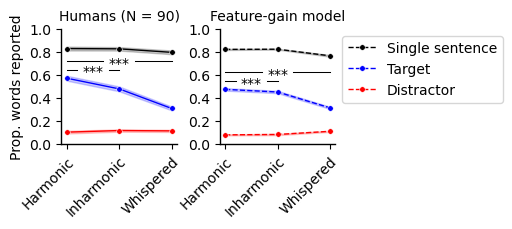

In [49]:

def draw_stats_bar(ax, x1, x2, y, h, text, th=0.025, lw=1.5, col='k', fontsize=10, text_gap=0.02):
    # Calculate the position of the text
    text_x = (x1 + x2) * 0.5
    text_y = y + th
    
    # Calculate the gap around the text
    gap_half_width = text_gap * len(text) # * (x2 - x1) * 0.5
    
    # Draw the left part of the bar
    ax.plot([x1, x1, text_x - gap_half_width], [y, y + h, y + h], lw=lw, c=col)
    
    # Draw the right part of the bar
    ax.plot([text_x + gap_half_width, x2, x2], [y + h, y + h, y], lw=lw, c=col)
    
    # Draw the text in the middle of the bar
    ax.text(text_x, y-0.02, text, ha='center', va='center', color=col, fontsize=fontsize)

group_order = ['Humans (N = 90)',
            'Feature-gain model',
            ]

groups_to_plot = group_order
n_models = len(groups_to_plot)

to_plot = results[results.group.isin(groups_to_plot)]
to_plot = to_plot[(to_plot.target_harmonicity == to_plot.distractor_harmonicity) | (to_plot.distractor_harmonicity == 'No Distractor')]
no_dist_IXS = to_plot[to_plot.distractor_harmonicity == 'No Distractor'].index.values
to_plot.loc[no_dist_IXS, 'distractor_harmonicity'] = to_plot.loc[no_dist_IXS, 'target_harmonicity'] 
to_plot =to_plot[to_plot.distractor_harmonicity != 'No Distractor']

hues = ['k', 'b', 'r']
hue_order = ['Single sentence', 'Target', 'Distractor']

palette = {'Target': 'b', 'Distractor': 'r', 'Single sentence': 'k'}

fontsize=10
tick_fontsize = 10
err_band_alpha = 0.2

yticks = np.linspace(0,1,6).round(1)

xtick_labels = to_plot.distractor_harmonicity.unique()
xticks = np.arange(len(xtick_labels))
ratio = 1.0 
line_thickness = 1
MARKER_SIZE = 8
aspect = 1.5
fig, axs = plt.subplots(1, n_models, figsize=((aspect) * (n_models + .5), aspect ))


for ax, model in zip(axs, group_order):
    sns.lineplot(data=to_plot[to_plot.group == model],  x='distractor_harmonicity', y='hits', 
                hue = 'attended_stream', hue_order=hue_order,
                palette=hues,
                ax=ax,
                errorbar=('se', 1), err_style='band', err_kws={'alpha':err_band_alpha},
                marker='.', 
                 )
    ax.set_title(model, fontsize=fontsize)
    ax.set_xlabel('')
    ax.set_ylim(0,1)
    ax.set_yticks(np.linspace(0,1,6).round(1))
    ax.set_xticklabels(xtick_labels, rotation=45, fontsize=tick_fontsize, ha='right', rotation_mode='anchor')
    xleft, xright = ax.get_xlim()
    ybottom, ytop = ax.get_ylim()
    ax.set_aspect(abs((xright-xleft)/(ybottom-ytop))*ratio)
    for line in ax.get_lines():
        line.set_linewidth(1)
        line.set_markersize(MARKER_SIZE)
        line.set_markeredgewidth(.4)
        if model != group_order[0]:
            line.set_linestyle('--')

    # set line thickness for pannel
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(line_thickness)
        ax.spines[axis].set_color('k')


## Add p-values to plot

# set up x and y positions for p-value text
x_coord_dict = {'Harmonic_Inharmonic': {'x1': 0, 'x2': 1},
                'Harmonic_Whispered': {'x1': 0, 'x2': 2},
                'Inharmonic_Whispered': {'x1': 1, 'x2': 2}}

# get y_pos for p-value text for target stream from data
group_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Harmonic')].groupby(['group']).hits.mean() + 0.0
inharmonic_max = to_plot[(to_plot.attended_stream == 'Target') & (to_plot.distractor_harmonicity == 'Inharmonic')].groupby(['group']).hits.mean() + 0.0
h = 0.025
ver_shift_increment = 0.075

for ax, model in zip(axs, groups_to_plot):
    if "Humans" in model:
        model_str = "Humans"
    else:
        model_str = model
    for stream in to_plot.attended_stream.unique():
        if stream != 'Target':
            continue
        for h_shift, harm_combo in enumerate(['Harmonic_Inharmonic', "Harmonic_Whispered"]):
            #get lead condition from str for x coordinate position
            first_cond, second_cond = harm_combo.split('_')
            cond_str = f"{first_cond} vs {second_cond}"
            print(model_str)
            print(cond_str)
            print(stream)

            p_val = ttest_df[(ttest_df.comparison == cond_str) & (ttest_df.group == model_str) & (ttest_df.stream == stream)].p.item()
            # if p_val < 0.05:
            #     text = "*"
            # if p_val < 0.001:
            #     text = "**"
            if p_val < 0.0001:
                text = "***"
            # text = f"$p<{p_val:.3f}$"
            x1 = x_coord_dict[harm_combo]['x1']
            x2 = x_coord_dict[harm_combo]['x2']
            ver_shift = ver_shift_increment * (h_shift + 1) 
            if harm_combo == 'Inharmonic_Whispered':
                y = inharmonic_max[model] + ver_shift_increment
            else:
                y = group_max[model] + ver_shift
            draw_stats_bar(ax, x1, x2, y, 0, text, col='k', lw=0.75, fontsize=fontsize, text_gap=0.1)
                
sns.despine()

for ix in range(n_models-1):
    axs[ix].legend().remove()

axs[0].set_ylabel("Prop. words reported", fontsize=fontsize)
for ix in range(1, n_models):
    axs[ix].set_ylabel("", fontsize=fontsize)

# move axs[1] legend 
axs[-1].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=fontsize)


# plt.savefig(fig_out_dir/'experiment_2.pdf', transparent=True, bbox_inches='tight')
